# Project outline

Our goal is to predict the healthcare costs of a municipality based on following predictors: population structure, alchohol and tobacco consumption and drug use, level of education and employment (possible to add others). Net expenditure means the costs after all revenue has been taken into account.

## The data

Our data was obtained from Finnish Statistical center and Finnish Institute of Health and Welfare.

Our target variable is the net healthcare expenditure of a municipality's healthcare cost, measured in euros per capita. The predictors can be broadly classified into population-related and environmental. 

The population-related predictors include: percentages of population aged 0-18, 18-64 and 65 and over, percentage of population posessing a higher education qualifications, litres of pure alcohol sold in a year.

Challenges: It was hard to find data at times, since we needed the data to be grouped by municipality and between years 1993 and 2020. Sometimes data like that was not avaiable, or there was too little of it. Some data that interests us is dependent on questionnaires (like amount of exercise and other habits). This leads to a lot of data missing from cetrain municipalities, since not every municipality is going to gather that data. Data that we could not find per region: exercise, tobacco use, obesity. 

In [420]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [421]:
# Total population by year and municipality
pop_total = pd.read_csv("data/pop_by_municipality.csv", sep=";", header=None, 
                         names=["category", "id", "municipality", "area_code", "gender", "year", "count", "pop_total"])

pop_total = pop_total[["municipality", "gender", "year", "pop_total"]]
pop_total = pop_total[np.where(pop_total["gender"] == "combined", True, False)]
pop_total = pop_total.drop(columns=["gender"])

# Total municipal health expenditure (euro per capita) by municipality and year
health_cost = pd.read_csv("data/health_per_capita_municipality.csv", sep=";", header=None, index_col=False,
                            names=["category", "id", "municipality", "area_code", "gender", "year", "health_cost"])

health_cost = health_cost[["municipality", "year", "health_cost"]]
data = pd.merge(pop_total, health_cost, how="inner", on=["year", "municipality"])
data.head()

,municipality,year,pop_total,health_cost
0,Akaa,1993,16142,667.6
1,Akaa,1994,16038,680.2
2,Akaa,1995,15986,751.3
3,Akaa,1996,15924,771.0
4,Akaa,1997,15840,832.4


Above we have data on health expenditure by year and municipality, measured in euro per capita. Note that this includes environmental health care. The other data set contains total population by gender, year and municipality. From this data set we picked the combined population, both male and female, and joined with healthcare cost data by year and municipality. 

In [422]:
# Population structure as total numbers and percentages by municipality, year and ages
pop_structure = pd.read_csv("data/pop_structure_municipality.csv", sep=";", header=None).drop(columns=[1, 3, 7])
pop_structure.columns = ["category", "municipality", "gender", "year", "percent"]


# Create new columns male_0_18, male_18_64, male_65, female_0_18, female_18_64, female_65, combined_0_18, combined_18_64, combined_65
pop_structure["male_0_18"] = np.where((pop_structure["category"] == "Population aged 0-18 as % of total population") 
                                      & (pop_structure["gender"] == "male"), pop_structure["percent"], 0)

pop_structure["male_18_64"] = np.where((pop_structure["category"] == "Population aged 18-64 as % of total population") 
                                      & (pop_structure["gender"] == "male"), pop_structure["percent"], 0)

pop_structure["male_65"] = np.where((pop_structure["category"] == "Population aged 65 and over as % of total population") 
                                      & (pop_structure["gender"] == "male"), pop_structure["percent"], 0)

pop_structure["female_0_18"] = np.where((pop_structure["category"] == "Population aged 0-18 as % of total population") 
                                      & (pop_structure["gender"] == "female"), pop_structure["percent"], 0)

pop_structure["female_18_64"] = np.where((pop_structure["category"] == "Population aged 18-64 as % of total population") 
                                      & (pop_structure["gender"] == "female"), pop_structure["percent"], 0)

pop_structure["female_65"] = np.where((pop_structure["category"] == "Population aged 65 and over as % of total population") 
                                      & (pop_structure["gender"] == "female"), pop_structure["percent"], 0)

pop_structure["combined_0_18"] = np.where((pop_structure["category"] == "Population aged 0-18 as % of total population") 
                                      & (pop_structure["gender"] == "combined"), pop_structure["percent"], 0)

pop_structure["combined_18_64"] = np.where((pop_structure["category"] == "Population aged 18-64 as % of total population") 
                                      & (pop_structure["gender"] == "combined"), pop_structure["percent"], 0)

pop_structure["combined_65"] = np.where((pop_structure["category"] == "Population aged 65 and over as % of total population") 
                                      & (pop_structure["gender"] == "combined"), pop_structure["percent"], 0)

# Drop percentage, total, gender and category, group by year and region and obtain sum
pop_structure = pop_structure.drop(columns=["category", "gender", "percent"])
pop_structure = pop_structure.groupby(["municipality", "year"], as_index=False).sum()

# Merge with previous data
data = pd.merge(pop_structure, data, how="inner", on=["year", "municipality"])
data.head()

# Convert numbers from percentages to absolute values by multiplying by total population if needed
#data.iloc[:, 2:11] = data.iloc[:, 2:11] * data[["pop_total"]].to_numpy()

,municipality,year,male_0_18,male_18_64,male_65,female_0_18,female_18_64,female_65,combined_0_18,combined_18_64,combined_65,pop_total,health_cost
0,Akaa,1993,24.7,64.6,12.0,22.8,58.0,20.5,23.7,61.2,16.4,16142,667.6
1,Akaa,1994,24.8,64.0,12.4,22.7,57.5,20.9,23.7,60.7,16.7,16038,680.2
2,Akaa,1995,24.7,64.0,12.7,22.8,57.2,21.1,23.7,60.5,17.0,15986,751.3
3,Akaa,1996,24.6,63.9,12.9,22.7,57.2,21.3,23.6,60.5,17.2,15924,771.0
4,Akaa,1997,24.1,63.9,13.1,22.7,57.0,21.4,23.4,60.4,17.3,15840,832.4


Here we have population structure data. We chose to split the population by gender and ages 0-18, 18-64 and 65 and over. This would yield 9 new predictors: for each of the age categories we have men, women and combined population. First we created those columns and then grouped by region and year and summed the values to get all observations into one row. Note! values are percentages of total population.

Next we will merge some data on education and employment into the data frame.

In [423]:
# load data, drop unnecessary column 
edu = pd.read_csv("data/education_municipality.csv", sep=';', header=None).drop(columns=[0, 1, 3, 7])
edu.columns = ["municipality", "gender", "year", "higher_education"]

# pivot by gender
edu_pivot = edu.pivot_table(index=["municipality", "year"], columns="gender", values="higher_education").reset_index()
edu_pivot.rename(columns={"combined": "combined_higher_education", "female": "female_higher_education", "male": "male_higher_education"}, inplace=True)

# only select relevant columns
edu_pivot = edu_pivot[["municipality", "year", "male_higher_education", "female_higher_education", "combined_higher_education"]]

# merge with previous data
data = pd.merge(edu_pivot, data, how="inner", on=["year", "municipality"])
data.head()

,municipality,year,male_higher_education,female_higher_education,combined_higher_education,male_0_18,male_18_64,male_65,female_0_18,female_18_64,female_65,combined_0_18,combined_18_64,combined_65,pop_total,health_cost
0,Akaa,1993,48.0,41.9,44.9,24.7,64.6,12.0,22.8,58.0,20.5,23.7,61.2,16.4,16142,667.6
1,Akaa,1994,48.5,43.0,45.7,24.8,64.0,12.4,22.7,57.5,20.9,23.7,60.7,16.7,16038,680.2
2,Akaa,1995,49.0,43.8,46.3,24.7,64.0,12.7,22.8,57.2,21.1,23.7,60.5,17.0,15986,751.3
3,Akaa,1996,49.7,44.6,47.1,24.6,63.9,12.9,22.7,57.2,21.3,23.6,60.5,17.2,15924,771.0
4,Akaa,1997,50.1,45.2,47.6,24.1,63.9,13.1,22.7,57.0,21.4,23.4,60.4,17.3,15840,832.4


Next we merged education data with the current data. The data set contains population with higher education qualifications, as percentage of total population aged 20 and over by gender. Data source: Educational structure of population (Statistics Finland).

In [424]:
# alchohol data, as litres of pure alcohol sold per capita
alcohol = pd.read_csv("data/alcohol_sales_municipality.csv", sep=";", header=None).drop(columns=[0, 1, 3, 4, 7])
alcohol.columns = ["municipality", "year", "alcohol_sales"]

data = pd.merge(alcohol, data, how="inner", on=["year", "municipality"])
data.head()

,municipality,year,alcohol_sales,male_higher_education,female_higher_education,combined_higher_education,male_0_18,male_18_64,male_65,female_0_18,female_18_64,female_65,combined_0_18,combined_18_64,combined_65,pop_total,health_cost
0,Akaa,1993,5.9,48.0,41.9,44.9,24.7,64.6,12.0,22.8,58.0,20.5,23.7,61.2,16.4,16142,667.6
1,Akaa,1994,5.8,48.5,43.0,45.7,24.8,64.0,12.4,22.7,57.5,20.9,23.7,60.7,16.7,16038,680.2
2,Akaa,1995,6.0,49.0,43.8,46.3,24.7,64.0,12.7,22.8,57.2,21.1,23.7,60.5,17.0,15986,751.3
3,Akaa,1996,6.0,49.7,44.6,47.1,24.6,63.9,12.9,22.7,57.2,21.3,23.6,60.5,17.2,15924,771.0
4,Akaa,1997,6.4,50.1,45.2,47.6,24.1,63.9,13.1,22.7,57.0,21.4,23.4,60.4,17.3,15840,832.4


Next we added data on alcohol sales measured in litres of pure alcohol sold in a year and wrote the data frame to csv file.  

In [425]:
data.to_csv("data/data_merged.csv")

Since municipalities in Finland change from time to time, we needed to figure out what split is being used in our data. Count of municipalities:

In [426]:
data.municipality.unique().shape

(309,)

There seems to be 309 municipalities, which is the current number (relevant since 2021). Therefore we assume that the municipalities by which the data was compiled, is the current one. 

### Environmental factors

Environmental factors that could affect healthcare expenditure include: quality of air and water, heat waves, radiation (for example UV radiation). For example by looking at municipalities that have mines could give an indication about the environment. Also percentage of forest areas vs. city. 

## Exploratory data analysis

Here is a map of health expenditure visualized on the map of Finland:

(309,)


<Axes: >

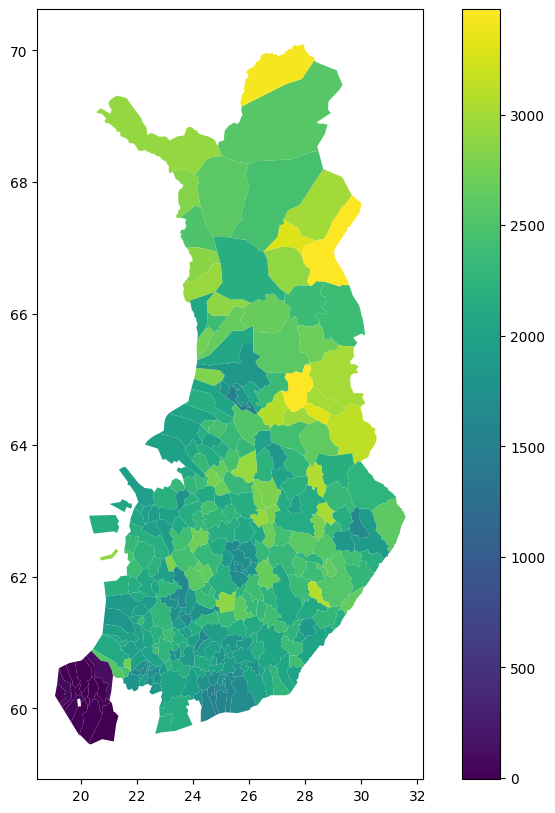

In [451]:
finland_map = gpd.read_file("data/municipalities.json")[["NAMEFIN", "geometry"]]
finland_map = finland_map.rename(columns={"NAMEFIN": "municipality"})
print(finland_map["municipality"].unique().shape)

data_2018 = data[np.where(data["year"] == 2018, True, False)][["health_cost", "municipality"]]

finland_map = pd.merge(finland_map, data_2018, how="outer", on=["municipality"])

finland_map.plot(column="health_cost", figsize=(10, 10), legend=True)

Some scatter plots to see the relationships between predictors: